<a href="https://colab.research.google.com/github/rebeckakarras/Lab3/blob/main/Steepestascent_kl17%3A20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [444]:
import pandas as pd
import numpy as np
from numpy.random import rand
import statsmodels.api as sm
import statsmodels.formula.api as smf

2-Level factorial design basis
Choosing a high and a low value
T_high = 40
T_low = 20
c_high = 3 mmol
c_low = 1 mmol
with 30.1 and 1.9 mmol as my centerpoints.


In [445]:
inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',15,35),
       ('B', 1 * 10**(-3),3*10**(-3)),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
A,15.000,35.000,Temperature
B,0.001,0.003,Concentration


In [446]:


inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,high,label,encoded_low,encoded_high
index,,,,,
A,15.000,35.000,Temperature,-1.0,1.0
B,0.001,0.003,Concentration,-1.0,1.0


In [447]:
import itertools
# we have four repetitions
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded = pd.DataFrame(encoded_inputs, columns=['T', 'c'])
encoded

,T,c
0,-1,-1
1,-1,1
2,1,-1
3,1,1


In [448]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df.head()

,A,B
0,15.0,0.001
1,15.0,0.003
2,35.0,0.001
3,35.0,0.003


In [449]:
#orginal data
results = [2.89998853,  3.40460836, 5.8830253,  12.03046496 ]

resultsorg = pd.DataFrame(results, columns=["y1"])
resultsorg

,y1
0,2.899989
1,3.404608
2,5.883025
3,12.030465


In [450]:
combined_output = pd.concat([encoded, resultsorg], axis=1)
combined_output

,T,c,y1
0,-1,-1,2.899989
1,-1,1,3.404608
2,1,-1,5.883025
3,1,1,12.030465


In [451]:
labels = ['T','c']

main_effects = {}
rep=1
for j in range(0,rep):
    index=j+1
    for key in labels:
        effects = combined_output.groupby(key)['y'+str(index)].mean()
        main_effects[j,key] = sum( [i*effects[i] for i in [-1,1]])

print('Main effects')
print(main_effects)

average_main_effects = {}
#this will be similar due to only two factors are used.
print('Average main effects')
for key in labels:
        average_effects = combined_output.groupby(key)['y1'].mean()
        average_main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(average_main_effects)

Main effects
{(0, 'T'): 5.804446685, (0, 'c'): 3.3260297450000005}
Average main effects
{'T': 5.804446685, 'c': 3.3260297450000005}


In [452]:
import itertools

twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = combined_output.groupby([key[0],key[1]])['y1'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('T', 'c'): 2.821409915}

In [453]:
effects=[] #pd.DataFrame({})
indexes=[]
for i,k in enumerate(average_main_effects.keys()):
    effects.append(abs(average_main_effects[k]))
    indexes.append(k)
for i,k in enumerate(twoway_effects.keys()):
    effects.append(abs(twoway_effects[k]))
    indexes.append(k)

effects_df=pd.DataFrame({"Standardized effect":effects})

# reset the indexes
effects_df.index=indexes
# Sort values in descending order
effects_df = effects_df.sort_values(by='Standardized effect', ascending=False)
# Add cumulative percentage column
effects_df["cummunalitive percentage"] = round(effects_df["Standardized effect"].cumsum()/effects_df["Standardized effect"].sum()*100,2)

# Display data frame
effects_df

,Standardized effect,cummunalitive percentage
T,5.804447,48.57
c,3.326030,76.39
"(T, c)",2.821410,100.00


Text(0.5, 1.0, 'y1')

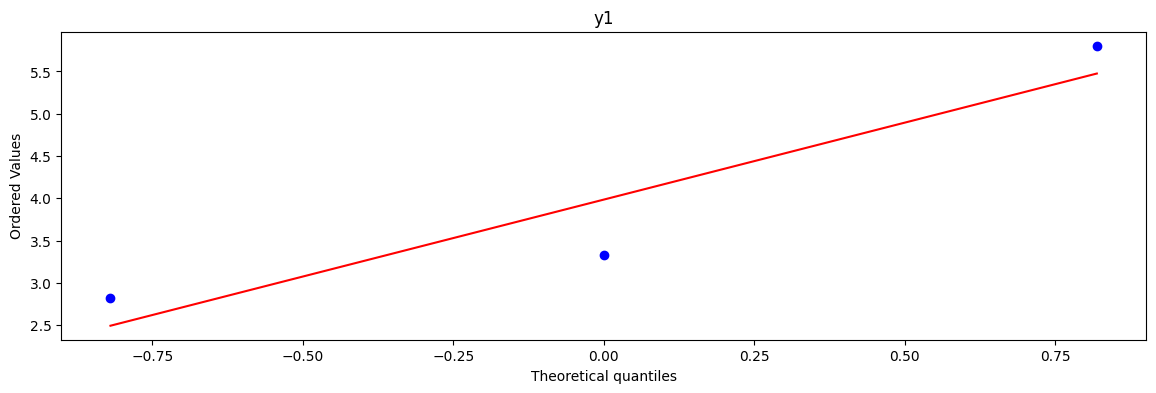

In [454]:
from matplotlib.pyplot import *
import scipy.stats as stats
fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(111)
#ax2 = fig.add_subplot(132)
#ax3 = fig.add_subplot(133)

stats.probplot(effects_df["Standardized effect"], dist="norm", plot=ax1)
ax1.set_title('y1')

In [455]:
s = "yhat = "

s += "%0.3f "%(combined_output['y1'].mean())

for i,k in enumerate(average_main_effects.keys()):
    if(average_main_effects[k]<0):
        s += "%0.3f %s "%( average_main_effects[k]/2.0, k )
    else:
        s += "+ %0.3f %s "%( average_main_effects[k]/2.0, k )

for i,k in enumerate(twoway_effects.keys()):
    if(twoway_effects[k]<0):
        s += " %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])
    else:
        s += "+ %0.3f %s %s"%( twoway_effects[k]/2.0, k[0],k[1])

print(s)

yhat = 6.055 + 2.902 T + 1.663 c + 1.411 T c


In [456]:
sigmasquared = 0.0050
k = len(inputs_df.index)
Vmean = (sigmasquared)/(2**k)
Veffect = (4*sigmasquared)/(2**k)
print("Variance in mean: %0.6f"%(Vmean))
print("Variance in effects: %0.6f"%(Veffect))

Variance in mean: 0.001250
Variance in effects: 0.005000


In [457]:
sigmasquared = 0.0050
r=4
k = len(inputs_df.index)
Vmean = (sigmasquared)/(r*2**k)
Veffect = (4*sigmasquared)/(r*2**k)
print("Variance in mean: %0.6f"%(Vmean))
print("Variance in effects: %0.6f"%(Veffect))

Variance in mean: 0.000313
Variance in effects: 0.001250


In [458]:
print(np.sqrt(Vmean))
print(np.sqrt(Veffect))

0.017677669529663688
0.035355339059327376


In [459]:
#no noise hence the perfect results.
y1 = combined_output['y1']
xlabs=['T','c']
x = combined_output[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='y1 ~ T + c + T:c', data=combined_output).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1527: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normal

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 08 Oct 2024   Prob (F-statistic):                nan
Time:                        15:17:16   Log-Likelihood:                 130.31
No. Observations:                   4   AIC:                            -252.6
Df Residuals:                       0   BIC:                            -255.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0545        inf          0        nan         nan         nan
T              2.9022        inf          0        nan         nan         nan
c              1.6630        inf          0        nan         nan         nan
T:c            1.4107        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.133
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.578
Skew:                          -0.115   Prob(JB):                        0.749
Kurtosis:                       1.152   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [460]:
res2 = smf.ols(formula='y1 ~ c + T + T:c + I(T**2) + I(c**2)', data=combined_output).fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 08 Oct 2024   Prob (F-statistic):                nan
Time:                        15:17:16   Log-Likelihood:                 127.90
No. Observations:                   4   AIC:                            -247.8
Df Residuals:                       0   BIC:                            -250.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0182        inf          0        n

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1527: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normal

Optimization

In [461]:
inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',15,25,35),
       ('B', 1.95,2,2.05),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','center','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,center,high,label
index,,,,
A,15.00,25,35.00,Temperature
B,1.95,2,2.05,Concentration


In [462]:
# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
A,15.00,25,35.00,Temperature,-1.0,0.0,1.0
B,1.95,2,2.05,Concentration,-1.0,0.0,1.0


In [463]:
import itertools
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs
for i in range(0,5):
    encoded_inputs.append((0,0))
encoded_inputs

[(-1, -1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]

In [464]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B']
results

,A,B
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0


In [465]:
def parse_values(x):
    if x < 2:
       return x * 10
    elif x < 4:
       return x ** 2
    else:
       return x + 10

real_experiment = results
var_labels = []
for var in ['A','B']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), axis=1)


real_experiment[var_labels]

,Temperature,Concentration
0,15.0,1.95
1,35.0,1.95
2,15.0,2.05
3,35.0,2.05
4,25.0,2.00
5,25.0,2.00
6,25.0,2.00
7,25.0,2.00
8,25.0,2.00


In [466]:
#need to randomize values for the centerpoints
import random
#Data gathered from Erik
experiment_results = [3.161645078398407, 8.818603462257467, 3.3010259130332984, 9.016058995325636, 5.68320685229769,
 5.789504000747021,
 5.863166591162294,
 5.647103571513824,
 5.747158560790277]
resultsorg = pd.DataFrame(experiment_results, columns=["y1"])
resultsorg

,y1
0,3.161645
1,8.818603
2,3.301026
3,9.016059
4,5.683207
5,5.789504
6,5.863167
7,5.647104
8,5.747159


In [467]:
df = pd.concat([results,resultsorg], axis=1)
df

,A,B,Temperature,Concentration,y1
0,-1,-1,15.0,1.95,3.161645
1,1,-1,35.0,1.95,8.818603
2,-1,1,15.0,2.05,3.301026
3,1,1,35.0,2.05,9.016059
4,0,0,25.0,2.00,5.683207
5,0,0,25.0,2.00,5.789504
6,0,0,25.0,2.00,5.863167
7,0,0,25.0,2.00,5.647104
8,0,0,25.0,2.00,5.747159


In [468]:
labels = ['A','B']
ybar = df['y1'].mean()
print(ybar)

main_effects = {}

print('main effects')
for key in labels:
        average_effects = df.groupby(key)['y1'].mean()
        main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(main_effects)

5.891941447280657
main effects
{'A': 5.685995733075699, 'B': 0.1684181838515295}


y = 5.88 + 3.326A + 5.804B + AB
A / 3.326 = 1 / 5.08

In [469]:
y1 = df['y1']
xlabs=['A','B']
x = df[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='y1 ~ A + B + A:B', data=df).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y1   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     200.6
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           1.25e-05
Time:                        15:17:16   Log-Likelihood:                 3.0280
No. Observations:                   9   AIC:                             1.944
Df Residuals:                       5   BIC:                             2.733
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8919      0.077     76.225      0.000       5.693       6.091
A              2.8430      0.116     24.520      0.000       2.545       3.141
B              0.0842      0.116      0.726      0.500      -0.214       0.382
A:B            0.0145      0.116      0.125      0.905      -0.284       0.313
==============================================================================
Omnibus:                        4.443   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                1.089
Skew:                          -0.078   Prob(JB):                        0.580
Kurtosis:                       1.303   Cond. No.                         1.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [470]:
est1 = sm.OLS(y1,x).fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     359.9
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           5.65e-07
Time:                        15:17:16   Log-Likelihood:                 3.0139
No. Observations:                   9   AIC:                          -0.02781
Df Residuals:                       6   BIC:                            0.5639
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8919      0.071     83.369      0.0

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  res = hypotest_fun_out(*samples, **kwds)


In [471]:
twoway_labels = list(itertools.combinations(labels, 2))


twoway_effects = {}
for key in twoway_labels:

    effects = df.groupby([key[0],key[1]])['y1'].mean()

    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
twoway_effects

{('A', 'B'): 0.029037349216638475}

Steepest ascent


In [472]:
B = main_effects['B']/main_effects['A']
B

0.029619822412428696

1/A =

In [473]:
Origin = [24,2-B]
delta= [1,B]
march=[]
for i in range(0,30):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['T', 'c'])
March

,T,c
0,25,2.000000
1,26,2.029620
2,27,2.059240
3,28,2.088859
4,29,2.118479
5,30,2.148099
6,31,2.177719
7,32,2.207339
8,33,2.236959
9,34,2.266578


Generating data points around the maximum found in the first round

In [474]:
import itertools
# we have four repetitions
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded = pd.DataFrame(encoded_inputs, columns=['T', 'c'])


In [475]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B']
results

,A,B
0,-1,-1
1,1,-1
2,-1,1
3,1,1


In [476]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df

,A,B
0,15.0,1.95
1,15.0,2.05
2,35.0,1.95
3,35.0,2.05


In [477]:
new_results = [8.789826866562874, 9.173031362039227, 9.913108913074604, 10.516592175016205 ]
new_df = pd.DataFrame(new_results, columns=['a'])
results_again = pd.concat([decoded_df,new_df], axis=1)
results_again

,A,B,a
0,15.0,1.95,8.789827
1,15.0,2.05,9.173031
2,35.0,1.95,9.913109
3,35.0,2.05,10.516592


In [478]:
df = pd.concat([encoded,results_again], axis=1)
df

,T,c,A,B,a
0,-1,-1,15.0,1.95,8.789827
1,-1,1,15.0,2.05,9.173031
2,1,-1,35.0,1.95,9.913109
3,1,1,35.0,2.05,10.516592


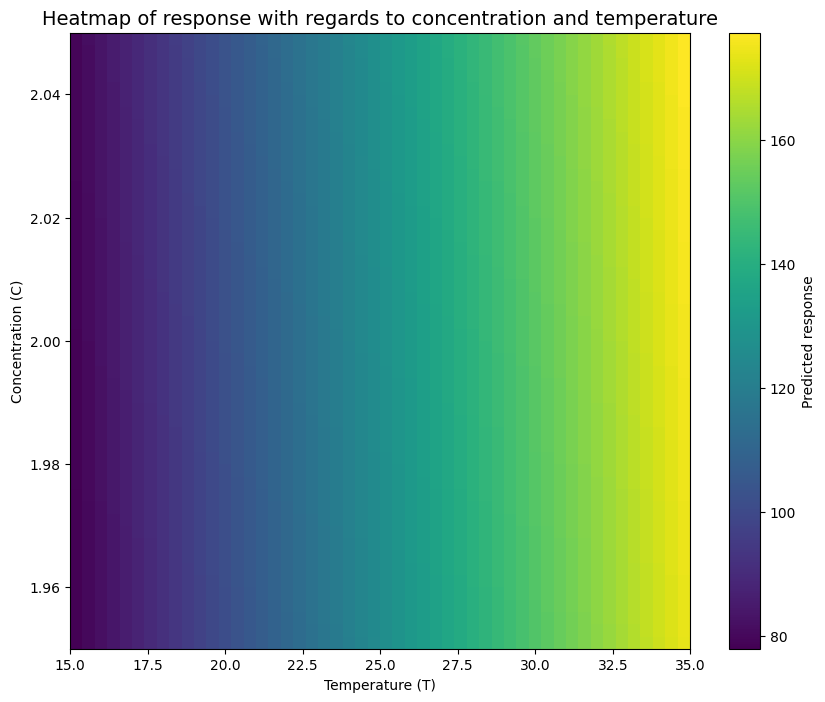

Max response: 177.31950999999998, Max concentration (c): 2.05, Max temperature (T): 35.0


In [479]:
import numpy as np
import matplotlib.pyplot as plt

# Example model parameters (you need to replace this with your actual model parameters)
# Replace these with actual values from your regression model
params = {
    "Intercept": 5.8919,  # Example intercept
    "c": 0.0842,          # Example coefficient for concentration (c)
    "T": 2.8430,          # Example coefficient for temperature (T)
           # Example interaction term coefficient
}

# Simulate a simple object to hold parameters similar to a model result
class Res:
    def __init__(self, params):
        self.params = params

res = Res(params)  # Create an instance with the above parameters

# Define the function for plotting the heat map
def heat_map(res, T_min, T_max, c_min, c_max):
    c = np.linspace(c_min, c_max, 50)  # Concentration values range
    T = np.linspace(T_min, T_max, 50)  # Temperature values range

    # Create a meshgrid for T and c
    T_grid, c_grid = np.meshgrid(T, c)

    # Extract the parameters from the model
    intercept = res.params["Intercept"]
    c_coef = res.params["c"]
    T_coef = res.params["T"]


    # Compute predicted response (yy) over the grid
    yy = intercept + c_coef * c_grid + T_coef * T_grid + c_grid * T_grid

    # Create the heatmap using plt.imshow()
    plt.figure(figsize=(10, 8))
    plt.imshow(yy, extent=[T_min, T_max, c_min, c_max], origin='lower', aspect='auto', cmap='viridis')

    # Add colorbar to show the hue (yy values)
    plt.colorbar(label='Predicted response')

    # Add labels and title
    plt.xlabel('Temperature (T)')
    plt.ylabel('Concentration (C)')
    plt.title('Heatmap of response with regards to concentration and temperature', fontsize=14)

    # Find the maximum value and its corresponding T and C values
    max_yy = np.max(yy)
    max_index = np.argmax(yy)  # Flattened index of max value

    # Convert flattened index to 2D indices
    max_2d_index = np.unravel_index(max_index, yy.shape)

    # Get the corresponding c and T values at the maximum point
    max_c_value = c_grid[max_2d_index]
    max_T_value = T_grid[max_2d_index]

    # Display the plot and print the maximum value details
    plt.show()

    print(f"Max response: {max_yy}, Max concentration (c): {max_c_value}, Max temperature (T): {max_T_value}")

# Example usage
T_min = 15  # Minimum temperature
T_max = 35  # Maximum temperature
c_min = 1.95  # Minimum concentration (example)
c_max = 2.05  # Maximum concentration (example)

# Call the function to generate the heatmap and print the maximum point
heat_map(res, T_min, T_max, c_min, c_max)

In [480]:

inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',32,38),
       ('B',2.207339, 2.385058),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
A,32.000000,38.000000,Temperature
B,2.207339,2.385058,Concentration


In [481]:
import itertools
# we have four repetitions
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded = pd.DataFrame(encoded_inputs, columns=['T', 'c'])
encoded

,T,c
0,-1,-1
1,-1,1
2,1,-1
3,1,1


In [482]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df.head()

,A,B
0,32.0,2.207339
1,32.0,2.385058
2,38.0,2.207339
3,38.0,2.385058


In [483]:
new_results = [8.789826866562874, 9.173031362039227, 9.913108913074604, 10.516592175016205]
new_df = pd.DataFrame(new_results, columns=['a'])
results_again = pd.concat([decoded_df,new_df], axis=1)
results_again

,A,B,a
0,32.0,2.207339,8.789827
1,32.0,2.385058,9.173031
2,38.0,2.207339,9.913109
3,38.0,2.385058,10.516592


In [484]:
df = pd.concat([encoded,results_again], axis=1)
df

,T,c,A,B,a
0,-1,-1,32.0,2.207339,8.789827
1,-1,1,32.0,2.385058,9.173031
2,1,-1,38.0,2.207339,9.913109
3,1,1,38.0,2.385058,10.516592


In [485]:
y1 = df['a']
xlabs=['A','B']
x = df[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='a ~ A + B + A:B', data=df).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      a   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 08 Oct 2024   Prob (F-statistic):                nan
Time:                        15:17:17   Log-Likelihood:                 108.18
No. Observations:                   4   AIC:                            -208.4
Df Residuals:                       0   BIC:                            -210.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.6312        inf          0        nan         nan         nan
A             -0.2688        inf         -0        nan         nan         nan
B             -4.4543        inf         -0        nan         nan         nan
A:B            0.2066        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.004
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.473
Skew:                           0.041   Prob(JB):                        0.790
Kurtosis:                       1.318   Cond. No.                     2.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

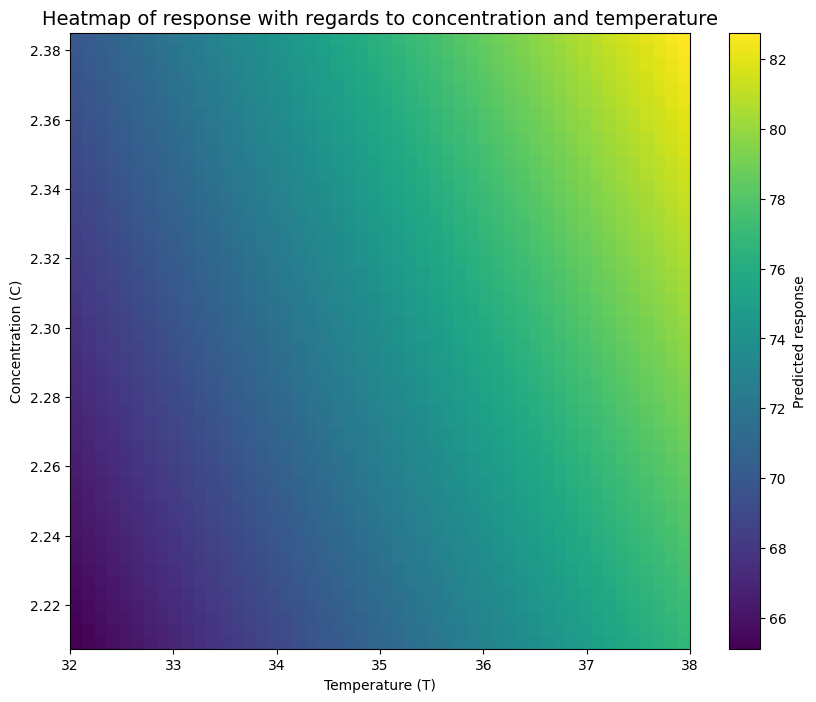

Max response: 82.7572550926, Max concentration (c): 2.385058, Max temperature (T): 38.0


In [496]:
import numpy as np
import matplotlib.pyplot as plt

# Example model parameters (you need to replace this with your actual model parameters)
# Replace these with actual values from your regression model
params = {
    "Intercept": 12.6312	,  # Example intercept
    "c": -4.4553,          # Example coefficient for concentration (c)
    "T": -0.26,          # Example coefficient for temperature (T)
             # Example interaction term coefficient
}

# Simulate a simple object to hold parameters similar to a model result
class Res:
    def __init__(self, params):
        self.params = params

res = Res(params)  # Create an instance with the above parameters

# Define the function for plotting the heat map
def heat_map(res, T_min, T_max, c_min, c_max):
    c = np.linspace(c_min, c_max, 50)  # Concentration values range
    T = np.linspace(T_min, T_max, 50)  # Temperature values range

    # Create a meshgrid for T and c
    T_grid, c_grid = np.meshgrid(T, c)

    # Extract the parameters from the model
    intercept = res.params["Intercept"]
    c_coef = res.params["c"]
    T_coef = res.params["T"]


    # Compute predicted response (yy) over the grid
    yy = intercept + c_coef * c_grid + T_coef * T_grid + c_grid * T_grid

    # Create the heatmap using plt.imshow()
    plt.figure(figsize=(10, 8))
    plt.imshow(yy, extent=[T_min, T_max, c_min, c_max], origin='lower', aspect='auto', cmap='viridis')

    # Add colorbar to show the hue (yy values)
    plt.colorbar(label='Predicted response')

    # Add labels and title
    plt.xlabel('Temperature (T)')
    plt.ylabel('Concentration (C)')
    plt.title('Heatmap of response with regards to concentration and temperature', fontsize=14)

    # Find the maximum value and its corresponding T and C values
    max_yy = np.max(yy)
    max_index = np.argmax(yy)  # Flattened index of max value

    # Convert flattened index to 2D indices
    max_2d_index = np.unravel_index(max_index, yy.shape)

    # Get the corresponding c and T values at the maximum point
    max_c_value = c_grid[max_2d_index]
    max_T_value = T_grid[max_2d_index]

    # Display the plot and print the maximum value details
    plt.show()

    print(f"Max response: {max_yy}, Max concentration (c): {max_c_value}, Max temperature (T): {max_T_value}")

# Example usage
T_min = 32  # Minimum temperature
T_max = 38  # Maximum temperature
c_min = 2.207339  # Minimum concentration (example)
c_max = 2.385058	  # Maximum concentration (example)

# Call the function to generate the heatmap and print the maximum point
heat_map(res, T_min, T_max, c_min, c_max)

In [487]:
labels = ['T','c']
ybar = df['a'].mean()
print(ybar)

main_effects = {}

print('main effects')
for key in labels:
        average_effects = df.groupby(key)['a'].mean()
        main_effects[key] = sum([i*average_effects[i] for i in [-1,1]])
print(main_effects)

9.598139829173228
main effects
{'T': 1.2334214297443538, 'c': 0.493343878708977}


In [488]:
Origin = [34,2.296198-B] #starting with the centerpoints
delta= [1,B]
march=[]
for i in range(0,15):
    march.append((Origin[0]+(i+1)*delta[0],Origin[1]+(i+1)*delta[1]))

March=pd.DataFrame(march,columns=['T', 'c'])
March

,T,c
0,35,2.296198
1,36,2.325818
2,37,2.355438
3,38,2.385057
4,39,2.414677
5,40,2.444297
6,41,2.473917
7,42,2.503537
8,43,2.533157
9,44,2.562776


In [489]:
inputs_labels = {'A' : 'Temperature',
                 'B' : 'Concentration',
                 }

dat = [('A',38,42),
       ('B',2.385058, 2.503537 ),
     ]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
A,38.000000,42.000000,Temperature
B,2.385058,2.503537,Concentration


In [490]:
import itertools
# we have four repetitions
encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded = pd.DataFrame(encoded_inputs, columns=['T', 'c'])


In [491]:
results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B']
results

,A,B
0,-1,-1
1,1,-1
2,-1,1
3,1,1


In [492]:
def decode_input(encoded_input, inputs_df):
    decoded_values = []
    for idx, val in enumerate(encoded_input):
        if val == -1:
            decoded_values.append(inputs_df.iloc[idx]['low'])
        else:
            decoded_values.append(inputs_df.iloc[idx]['high'])
    return decoded_values

# Apply the decoding function to each encoded input
decoded_experiments = [decode_input(encoded_input, inputs_df) for encoded_input in encoded_inputs]

# Create a new DataFrame with the decoded values
decoded_df = pd.DataFrame(decoded_experiments, columns=inputs_labels)
decoded_df

,A,B
0,38.0,2.385058
1,38.0,2.503537
2,42.0,2.385058
3,42.0,2.503537


In [493]:
results_new = [10.942216734063116,
 11.059939809057575,
 10.499544979640778,
 11.128698570890297]
res_df = pd.DataFrame(results_new, columns=['y'])
df = pd.concat([decoded_df,res_df ], axis=1)
df

,A,B,y
0,38.0,2.385058,10.942217
1,38.0,2.503537,11.059940
2,42.0,2.385058,10.499545
3,42.0,2.503537,11.128699


In [494]:
y1 = df['y']
xlabs=['A','B']
x = df[xlabs]
x = sm.add_constant(x)

res1 = smf.ols(formula='y ~ A + B', data=df).fit()

res1.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     1.334
Date:                Tue, 08 Oct 2024   Prob (F-statistic):              0.522
Time:                        15:17:18   Log-Likelihood:                 2.5516
No. Observations:                   4   AIC:                            0.8968
Df Residuals:                       1   BIC:                           -0.9443
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0729      5.864      0.865      0.546     -69.437      79.583
A             -0.0467      0.064     -0.731      0.598      -0.859       0.766
B              3.1519      2.158      1.460      0.382     -24.272      30.576
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.667
Skew:                           0.000   Prob(JB):                        0.717
Kurtosis:                       1.000   Cond. No.                     1.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

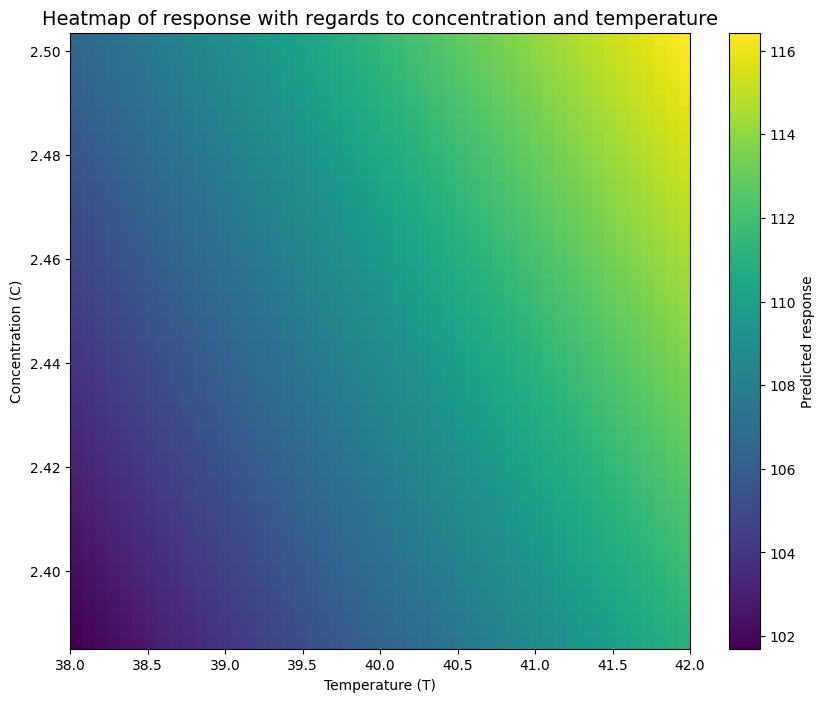

Max response: 116.42759555, Max concentration (c): 2.503537, Max temperature (T): 42.0


In [495]:
import numpy as np
import matplotlib.pyplot as plt

# Example model parameters (you need to replace this with your actual model parameters)
# Replace these with actual values from your regression model
params = {
    "Intercept": 5.0729	,  # Example intercept
    "c": 3.15,          # Example coefficient for concentration (c)
    "T": -0.04,          # Example coefficient for temperature (T)
             # Example interaction term coefficient
}

# Simulate a simple object to hold parameters similar to a model result
class Res:
    def __init__(self, params):
        self.params = params

res = Res(params)  # Create an instance with the above parameters

# Define the function for plotting the heat map
def heat_map(res, T_min, T_max, c_min, c_max):
    c = np.linspace(c_min, c_max, 50)  # Concentration values range
    T = np.linspace(T_min, T_max, 50)  # Temperature values range

    # Create a meshgrid for T and c
    T_grid, c_grid = np.meshgrid(T, c)

    # Extract the parameters from the model
    intercept = res.params["Intercept"]
    c_coef = res.params["c"]
    T_coef = res.params["T"]


    # Compute predicted response (yy) over the grid
    yy = intercept + c_coef * c_grid + T_coef * T_grid + c_grid * T_grid

    # Create the heatmap using plt.imshow()
    plt.figure(figsize=(10, 8))
    plt.imshow(yy, extent=[T_min, T_max, c_min, c_max], origin='lower', aspect='auto', cmap='viridis')

    # Add colorbar to show the hue (yy values)
    plt.colorbar(label='Predicted response')

    # Add labels and title
    plt.xlabel('Temperature (T)')
    plt.ylabel('Concentration (C)')
    plt.title('Heatmap of response with regards to concentration and temperature', fontsize=14)

    # Find the maximum value and its corresponding T and C values
    max_yy = np.max(yy)
    max_index = np.argmax(yy)  # Flattened index of max value

    # Convert flattened index to 2D indices
    max_2d_index = np.unravel_index(max_index, yy.shape)

    # Get the corresponding c and T values at the maximum point
    max_c_value = c_grid[max_2d_index]
    max_T_value = T_grid[max_2d_index]

    # Display the plot and print the maximum value details
    plt.show()

    print(f"Max response: {max_yy}, Max concentration (c): {max_c_value}, Max temperature (T): {max_T_value}")

# Example usage
T_min = 38  # Minimum temperature
T_max = 42  # Maximum temperature
c_min = 2.385058  # Minimum concentration (example)
c_max = 2.503537	  # Maximum concentration (example)

# Call the function to generate the heatmap and print the maximum point
heat_map(res, T_min, T_max, c_min, c_max)
